#### Проверка доступности CUDA & cuDNN


In [ ]:
!python scripts/check-cuda.py

#### Cоздает и обучает нейронную сеть для классификации рукописных цифр из набора данных MNIST с использованием TensorFlow и Keras для построения последовательной модели.


In [ ]:
!python scripts/mnist-test.py

# 1. Подготовка


## 1.1 Установка зависимостей


In [ ]:
!pip install tf-nightly[and-cuda] keras opencv-python matplotlib

## 1.2 Импортирование стандартных зависимостей


In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

## 1.3 Импортирование зависимостей TensorFlow (Функциональный API)


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.4 Установка роста потребления памяти GPU для предотвращения ошибо OOM.


In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

## 1.5 Создание структуры директорий


#### Установка путей


In [4]:
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

INPUT_IMG_DIR_PATH = os.path.join("application_data", "input_image")
VERIF_IMG_DIR_PATH = os.path.join("application_data", "verification_images")

INPUT_IMG_PATH = os.path.join(INPUT_IMG_DIR_PATH, "input_image.jpg")

DIRECTORIES = [POS_PATH, NEG_PATH, ANC_PATH, INPUT_IMG_DIR_PATH, VERIF_IMG_DIR_PATH]

#### Создание директорий


In [5]:
for dir in DIRECTORIES:
    try:
        os.makedirs(dir)
    except FileExistsError:
        print(f"Директория {dir} уже существует")

Директория data\positive уже существует
Директория data\negative уже существует
Директория data\anchor уже существует
Директория application_data\input_image уже существует
Директория application_data\verification_images уже существует


# 2 Сбор данных


Скачать все изображения в виде gzip-tar-файла https://vis-www.cs.umass.edu/lfw/#download


## 2.1 Распаковка набора данных


In [23]:
DATASET_NAME = "lfw"
DATASET_EXTENSION = ".tgz"

In [24]:
import tarfile

try:
    with tarfile.open(DATASET_NAME + DATASET_EXTENSION, "r:gz") as tar:
        tar.extractall()
except FileNotFoundError as e:
    print(e.strerror)

No such file or directory


In [25]:
try:
    os.remove(DATASET_NAME + DATASET_EXTENSION)
except OSError as e:
    print(e.strerror)

The system cannot find the file specified


## 2.2 Перемещение изображений в директорию data/negative


In [26]:
try:
    for directory in os.listdir(DATASET_NAME):
        for file in os.listdir(os.path.join(DATASET_NAME, directory)):
            EX_PATH = os.path.join(DATASET_NAME, directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)
except FileNotFoundError as e:
    print(e.strerror)

The system cannot find the path specified


In [27]:
try:
    os.rmdir("lfw")
except OSError as e:
    print(e.strerror)

The system cannot find the file specified


## 2.3 Сбор позитивных и якорных изображений


#### Библиотека для создания уникальных названий изображений.


In [28]:
import uuid

In [29]:
# Установка соединения с веб-камерой
cap = cv2.VideoCapture(0)

# Отключение панели инструментов OpenCV
cv2.namedWindow("Image Collection", cv2.WINDOW_GUI_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()

    # Обрезание кадра до 250x250px
    frame = frame[115 : 115 + 250, 195 : 195 + 250, :]

    if cv2.waitKey(1) & 0xFF == ord("a"):
        # Создание уникального названия изображения
        imgname = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        # Запись образца
        cv2.imwrite(imgname, frame)
        print(f"Сохранено изображение {imgname}")

    if cv2.waitKey(1) & 0xFF == ord("p"):
        # Создание уникального названия изображения
        imgname = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        # Запись образца
        cv2.imwrite(imgname, frame)
        print(f"Сохранено изображение {imgname}")

    cv2.imshow("Image Collection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

Сохранено изображение data\anchor\0322ad4d-ae49-11ee-bafc-00155db61aec.jpg
Сохранено изображение data\positive\0e3dedaa-ae49-11ee-9855-00155db61aec.jpg


## 2.4 Дополнение данных


In [ ]:
def data_aug(img):
    data = []
    for i in range(5):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        img = tf.image.stateless_random_flip_left_right(
            img, seed=(np.random.randint(100), np.random.randint(100))
        )
        img = tf.image.stateless_random_jpeg_quality(
            img,
            min_jpeg_quality=90,
            max_jpeg_quality=100,
            seed=(np.random.randint(100), np.random.randint(100)),
        )
        img = tf.image.stateless_random_saturation(
            img,
            lower=0.9,
            upper=1,
            seed=(np.random.randint(100), np.random.randint(100)),
        )
        data.append(img)
    return data

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(
            os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1())), image.numpy()
        )

# 3 Загрузка и предобработка изображений


## 3.1 Получение каталогов изображений


In [30]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, "*.jpg")).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, "*.jpg")).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, "*.jpg")).take(13233)

## 3.2 Предобработка - масштабирование и изменение размера


In [31]:
def preprocess(file_path):
    # Чтение изображения
    byte_img = tf.io.read_file(file_path)
    # Загрузка изображения
    img = tf.io.decode_jpeg(byte_img)
    # Изменение размера изображения на 105x105
    img = tf.image.resize(img, (105, 105))
    # Масштабирование изображения в диапазоне от 0 до 1
    img = img / 255.0

    return img

## 3.3 Создание помеченного набора данных


In [32]:
positives = tf.data.Dataset.zip(
    (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
)

negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
)

data = positives.concatenate(negatives)

## 3.4 Сборка тренировочных и тестовых данных


In [33]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

#### Создание загрузчика данных


In [34]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

#### Данные для обучения


In [35]:
train_data = data.take(round(len(data) * 0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

#### Данные для тестирования


In [36]:
test_data = data.skip(round(len(data) * 0.8))
test_data = test_data.take(round(len(data) * 0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Разработка модели


## 4.1 Построение слоя внедрения


In [37]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name="input_image")

    # Первый блок
    c1 = Conv2D(64, (10, 10), activation=tf.nn.relu)(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Второй блок
    c2 = Conv2D(128, (7, 7), activation=tf.nn.relu)(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Трейтий блок
    c3 = Conv2D(128, (4, 4), activation=tf.nn.relu)(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Последний блок внедрения
    c4 = Conv2D(256, (4, 4), activation=tf.nn.relu)(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation=tf.nn.sigmoid)(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 4.2 Построение слоя расстояния


In [40]:
# Сиамский класс дистанции L1
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # Вычисление схожести
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [41]:
@tf.keras.utils.register_keras_serializable(name="ConcatLayer")
class ConcatLayer(Layer):
    def __init__(self, axis=0, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.concat(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

## 4.3 Создание сиамской модели


In [42]:
def make_siamese_model():
    input_image = Input(name="input_img", shape=(105, 105, 3))

    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    inp_embedding = ConcatLayer()(embedding(input_image))
    val_embedding = ConcatLayer()(embedding(validation_image))

    # Объединение компонентов сиамского расстояния
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(inp_embedding, val_embedding)

    # Слой классификации
    classifier = Dense(1, activation=tf.nn.sigmoid)(distances)

    return Model(
        inputs=[input_image, validation_image],
        outputs=classifier,
        name="SiameseNetwork",
    )

In [43]:
siamese_model = make_siamese_model()

In [44]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Обучение


## 5.1 Настройка потерь и оптимизатора


In [45]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

## 5.2 Установка контрольных точек


In [47]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, model=siamese_model)

## 5.3 Построение функции шага обучения


In [49]:
@tf.function
def train_step(batch):
    # Запись всех операций
    with tf.GradientTape() as tape:
        # Получение позитивного/негативного изображения
        X = batch[:2]
        # Получение метки
        y = batch[2]

        yhat = siamese_model(X, training=True)
        # Вычисление потерь
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Вычисление градиентов
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Вычисление обновленных весов и применение их к сиамской модели.
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 5.4 Построение цикла обучения


In [50]:
# Импортирование классов для вычисления точности и памяти модели
from tensorflow.keras.metrics import Precision, Recall

In [51]:
def train(data, EPOCHS):
    # Цикл по эпохам
    for epoch in range(1, EPOCHS + 1):
        print("\n Эпоха {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Создание объектов метрик
        r = Recall()
        p = Precision()

        # Цикл по каждой партии
        for idx, batch in enumerate(data):
            # Запуск шага обучения
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Сохранение контрольных точек
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Обучение модели


In [52]:
EPOCHS = 10

In [ ]:
train(train_data, EPOCHS)

# 6. Оценка модели


## 6.1 Прогнозы


In [53]:
# Получение партии тестовых данных
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [54]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 409ms/step


In [55]:
# Постобработка результатов
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1]

In [56]:
y_true

array([0., 1.], dtype=float32)

## 6.2 Вычисление показателей


In [57]:
# Создание экземпляров показателей
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    # Вычисление значений показателей
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)
# Вывод результатов
print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 247ms/step
1.0 0.5


## 6.3 Визуализация результатов


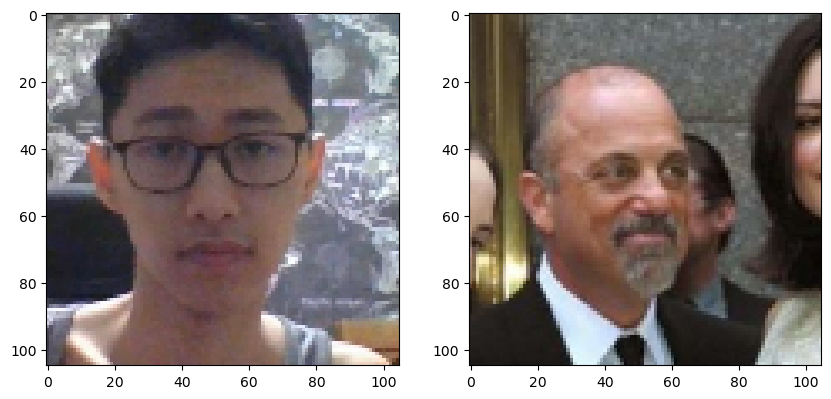

In [58]:
# Установка размера
plt.figure(figsize=(10, 8))

# Установка первого изображения
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Установка второго изображения
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

plt.show()

# 7. Сохранение модели


In [59]:
siamese_model.save("siamese_model.keras")

# 8 Загрузка модели


In [60]:
siamese_model = tf.keras.models.load_model(
    "siamese_model.keras", custom_objects={"L1Dist": L1Dist}
)

#### Оценка прогнозов загруженной модели


In [61]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 364ms/step


array([[0.00124915],
       [0.48436457]], dtype=float32)

In [62]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 9 Проверка работы модели в реальном времени


## 9.1 Функция подтверждения


In [64]:
for image in os.listdir(VERIF_IMG_PATH):
    validation_img = os.path.join(VERIF_IMG_PATH, image)
    print(validation_img)

application_data\verification_images\605aaca2-aa01-11ee-9305-00155d4bec0f.jpg
application_data\verification_images\6b75d4ae-aa01-11ee-9305-00155d4bec0f.jpg
application_data\verification_images\96dd0ae3-ae08-11ee-9c67-00155def1613.jpg


In [65]:
def verify(model, detection_threshold, verification_threshold):
    # Построение массива результатов прогнозов
    results = []
    for image in os.listdir(VERIF_IMG_PATH):
        input_img = preprocess(INPUT_IMG_PATH)
        validation_img = preprocess(os.path.join(VERIF_IMG_PATH, image))

        # Результаты прогнозов
        result = model.predict(
            list(np.expand_dims([input_img, validation_img], axis=1))
        )
        results.append(result)

    # Порог обнаружения: Показатель, прогноз выше которого  считается положительным
    detection = np.sum(np.array(results) > detection_threshold)

    # Порог подтверждения: Доля положительных прогнозов / Общее количество положительных образцов
    verification = detection / len(os.listdir(VERIF_IMG_PATH))
    verified = verification > verification_threshold

    return results, verified

## 9.2 Распознавание лица в реальном времени с OpenCV


In [66]:
cap = cv2.VideoCapture(0)

# Отключение панели инструментов OpenCV
cv2.namedWindow("Verification", cv2.WINDOW_GUI_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow("Verification", frame)

    # Триггер проверки
    if cv2.waitKey(1) & 0xFF == ord("v"):
        cut_frame = frame[120 : 120 + 250, 200 : 200 + 250, :]
        # Сохранение входного изображения в директорию application_data/input_image
        hsv = cv2.cvtColor(cut_frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(INPUT_IMG_PATH, cut_frame)
        # Подтверждение
        results, verified = verify(siamese_model, 0.7, 0.4)
        print(verified)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 217ms/step
False
1/1 [==============================] - 0s 217ms/step
False
1/1 [==============================] - 0s 220ms/step
False
1/1 [==============================] - 0s 219ms/step
False
1/1 [==============================] - 0s 241ms/step
False
1/1 [==============================] - 0s 227ms/step
False
1/1 [==============================] - 0s 220ms/step
False
1/1 [==============================] - 0s 218ms/step
False


In [67]:
np.sum(np.squeeze(results) > 0.9)

0

In [68]:
results

[array([[0.50326824]], dtype=float32),
 array([[0.08727527]], dtype=float32),
 array([[0.01921232]], dtype=float32)]